In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import cross_comparison
from itertools import accumulate
import torch


rust = False

if rust:
    sys.path.insert(0, os.path.abspath("/Users/jarrettye/Codes/anki/pylib"))
    sys.path.insert(0, os.path.abspath("/Users/jarrettye/Codes/anki/out/pylib"))

    from anki._backend import RustBackend

    backend = RustBackend()
    
    from anki.collection import FsrsItem, FsrsReview

In [2]:
from tqdm import tqdm
tqdm.pandas()

def convert_to_items(df):  # -> list[FsrsItem]

    def accumulate(group):
        items = []
        for _, row in group.iterrows():
            t_history = [max(0, int(t)) for t in row["t_history"].split(",")] + [
                row["delta_t"]
            ]
            r_history = [int(t) for t in row["r_history"].split(",")] + [row["rating"]]
            items.append(
                FsrsItem(
                    reviews=[
                        FsrsReview(delta_t=int(x[0]), rating=int(x[1]))
                        for x in zip(t_history, r_history)
                    ]
                )
            )
        return items

    result_list = sum(
        df.sort_values(by=["card_id", "review_th"])
        .groupby("card_id")
        .apply(accumulate)
        .tolist(),
        [],
    )

    return result_list


def cum_concat(x):
    return list(accumulate(x))


def create_time_series(df):
    df = df[(df["delta_t"] != 0) & (df["rating"].isin([1, 2, 3, 4]))].copy()
    df["i"] = df.groupby("card_id").cumcount() + 1
    t_history = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    r_history = df.groupby("card_id", group_keys=False)["rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history for item in sublist
    ]
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history for item in sublist
    ]
    df["tensor"] = [
        torch.tensor((t_item[:-1], r_item[:-1])).transpose(0, 1)
        for t_sublist, r_sublist in zip(t_history, r_history)
        for t_item, r_item in zip(t_sublist, r_sublist)
    ]
    df["y"] = df["rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    return df[df["delta_t"] > 0].sort_values(by=["review_th"]).reset_index(drop=True)

In [3]:
file = Path("../dataset/1000.csv")
dataset = pd.read_csv(file)
dataset = create_time_series(dataset)

  0%|          | 0/27 [00:00<?, ?it/s]

Pretrain finished!


  0%|          | 0/27 [00:00<?, ?it/s]

dataset built


train:   0%|          | 0/3230 [00:00<?, ?it/s]

  4%|▎         | 1/27 [00:00<00:15,  1.67it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/7385 [00:00<?, ?it/s]

  7%|▋         | 2/27 [00:00<00:10,  2.43it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/11280 [00:00<?, ?it/s]

 11%|█         | 3/27 [00:01<00:09,  2.48it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/15690 [00:00<?, ?it/s]

 15%|█▍        | 4/27 [00:01<00:09,  2.30it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/20310 [00:00<?, ?it/s]

 19%|█▊        | 5/27 [00:02<00:10,  2.05it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/23785 [00:00<?, ?it/s]

 22%|██▏       | 6/27 [00:03<00:11,  1.80it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/27340 [00:00<?, ?it/s]

 26%|██▌       | 7/27 [00:03<00:11,  1.69it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/30820 [00:00<?, ?it/s]

 30%|██▉       | 8/27 [00:04<00:12,  1.47it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/34745 [00:00<?, ?it/s]

 33%|███▎      | 9/27 [00:05<00:13,  1.36it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/39470 [00:00<?, ?it/s]

 37%|███▋      | 10/27 [00:06<00:13,  1.26it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/42715 [00:00<?, ?it/s]

 41%|████      | 11/27 [00:07<00:14,  1.13it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/46695 [00:00<?, ?it/s]

 44%|████▍     | 12/27 [00:08<00:14,  1.06it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/51130 [00:00<?, ?it/s]

 48%|████▊     | 13/27 [00:09<00:14,  1.01s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/55430 [00:00<?, ?it/s]

 52%|█████▏    | 14/27 [00:11<00:14,  1.12s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/59855 [00:00<?, ?it/s]

 56%|█████▌    | 15/27 [00:12<00:14,  1.23s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/64835 [00:00<?, ?it/s]

 59%|█████▉    | 16/27 [00:14<00:14,  1.33s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/69790 [00:00<?, ?it/s]

 63%|██████▎   | 17/27 [00:15<00:14,  1.41s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/74735 [00:00<?, ?it/s]

 67%|██████▋   | 18/27 [00:17<00:13,  1.53s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/79735 [00:00<?, ?it/s]

 70%|███████   | 19/27 [00:19<00:13,  1.66s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/84210 [00:00<?, ?it/s]

 74%|███████▍  | 20/27 [00:21<00:12,  1.74s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/89025 [00:00<?, ?it/s]

 78%|███████▊  | 21/27 [00:24<00:11,  1.94s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/94025 [00:00<?, ?it/s]

 81%|████████▏ | 22/27 [00:26<00:10,  2.08s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/99025 [00:00<?, ?it/s]

 85%|████████▌ | 23/27 [00:29<00:08,  2.24s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/104025 [00:00<?, ?it/s]

 89%|████████▉ | 24/27 [00:31<00:07,  2.42s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/109025 [00:00<?, ?it/s]

 93%|█████████▎| 25/27 [00:34<00:05,  2.63s/it]

Pretrain finished!


 93%|█████████▎| 25/27 [00:35<00:05,  2.63s/it]

dataset built


train:   0%|          | 0/114025 [00:00<?, ?it/s]

 96%|█████████▋| 26/27 [00:38<00:02,  2.82s/it]

Pretrain finished!


 96%|█████████▋| 26/27 [00:38<00:02,  2.82s/it]

dataset built


train:   0%|          | 0/118950 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:41<00:00,  1.54s/it]


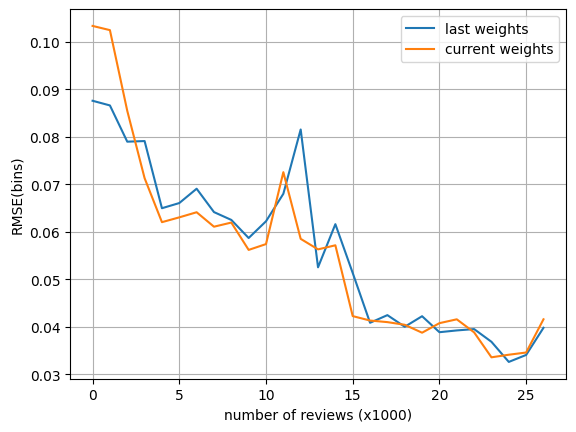

In [4]:
from fsrs_optimizer import (
    Optimizer,
    Collection,
    Trainer,
    power_forgetting_curve,
)

optimizer = Optimizer()
optimizer.define_model()

def evaluate(weights):
    my_collection = Collection(weights)
    stabilities, difficulties = my_collection.batch_predict(train_set)
    stabilities = map(lambda x: round(x, 2), stabilities)
    difficulties = map(lambda x: round(x, 2), difficulties)
    train_set["stability"] = list(stabilities)
    train_set["difficulty"] = list(difficulties)
    train_set["p"] = power_forgetting_curve(train_set["delta_t"], train_set["stability"])
    y = train_set["y"].tolist()
    p = train_set["p"].tolist()
    rmse_bins = cross_comparison(pd.DataFrame({"y": y, "R (FSRS)": p}), "FSRS", "FSRS")[
        0
    ]
    return rmse_bins


lr: float = 4e-2
n_epoch: int = 5
n_splits: int = 5
batch_size: int = 512
verbose: bool = False

last_weights = optimizer.init_w

m_last = []
m_cur = []
for max_index in tqdm(range(1000, len(dataset), 1000)):
    train_set = dataset.loc[:max_index].copy()
    if rust:
        items = convert_to_items(train_set[train_set["i"] >= 2])
        weights = backend.compute_weights_from_items(items)
    else:
        optimizer.S0_dataset_group = (
            train_set[train_set["i"] == 2]
            # .groupby(by=["first_rating", "delta_t"], group_keys=False)
            .groupby(by=["r_history", "delta_t"], group_keys=False)
            .agg({"y": ["mean", "count"]})
            .reset_index()
        )
        _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
        trainer = Trainer(
            train_set,
            train_set,
            optimizer.init_w,
            n_epoch=n_epoch,
            lr=lr,
            batch_size=batch_size,
        )
        weights = trainer.train(verbose=verbose)
    m_last.append(evaluate(last_weights))
    m_cur.append(evaluate(weights))
    last_weights = weights

plt.plot(m_last, label="last weights")
plt.plot(m_cur, label="current weights")
plt.xlabel("number of reviews (x1000)")
plt.ylabel("RMSE(bins)")
plt.legend()
plt.grid()
plt.show()